<a href="https://colab.research.google.com/github/dhruvidesai20/AI-Investment-ChatBot-SOC-2024/blob/main/SOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [509]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()
from time import time
import seaborn as sns
import warnings as wr
wr.filterwarnings("ignore")

In [510]:
def parser(s):
    return datetime.strptime(s,'%Y-%m-%d')

READING IN THE DATA

In [511]:
tickerSymbol= 'MSFT'
start_date= datetime(2018,1,1)
end_date= datetime(2023,1,1)

In [512]:
tickerData = yf.Ticker(tickerSymbol)
stockData = tickerData.history(period='1d',start=start_date, end=end_date)
stockData= stockData[['Close']]
stockData.index = stockData.index.date
stockData.index = pd.to_datetime(stockData.index)

In [513]:
print(stockData.head())

                Close
2018-01-02  79.936737
2018-01-03  80.308739
2018-01-04  81.015587
2018-01-05  82.020020
2018-01-08  82.103729


EDA

In [514]:
#Checking for null values
print("Missing values: ", stockData.isnull().sum())

Missing values:  Close    0
dtype: int64


In [515]:
print(stockData.info())
print(stockData.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-02 to 2022-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1259 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB
None
             Close
count  1259.000000
mean    187.776437
std      74.598653
min      79.062492
25%     113.665096
50%     194.930222
75%     249.983864
max     335.709839


<Axes: >

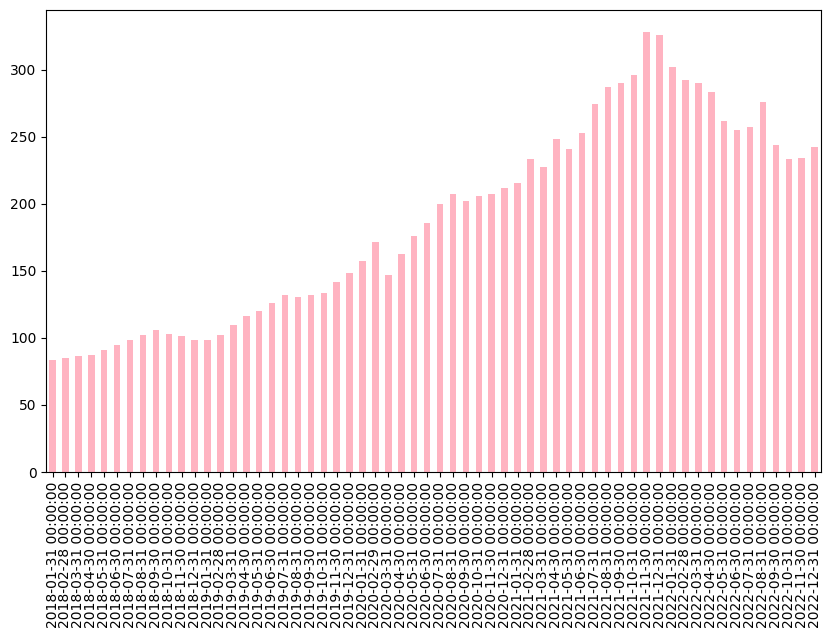

In [516]:
stockData['Close'].resample('M').mean().plot(kind='bar', figsize=(10,6), color='#FFB3C1')

<Axes: >

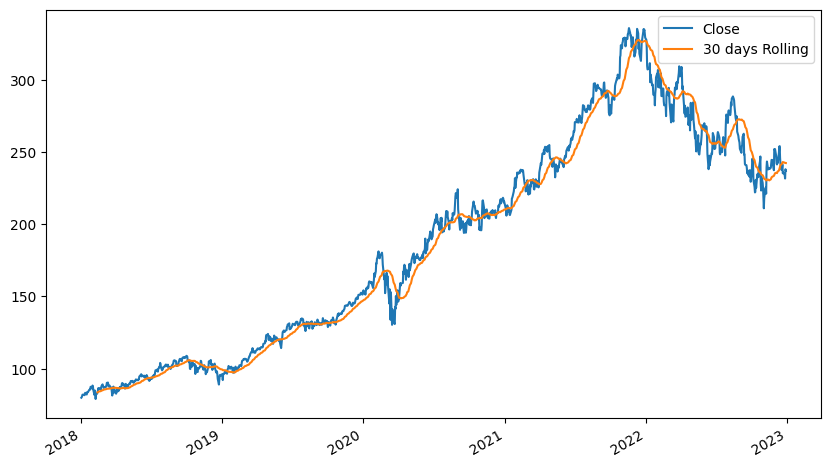

In [517]:
stockData['30 days Rolling']= stockData['Close'].rolling(window=30).mean()
stockData[['Close', '30 days Rolling']].plot(figsize=(10,6))

SIMPLE MOVING AVERAGE

<Axes: >

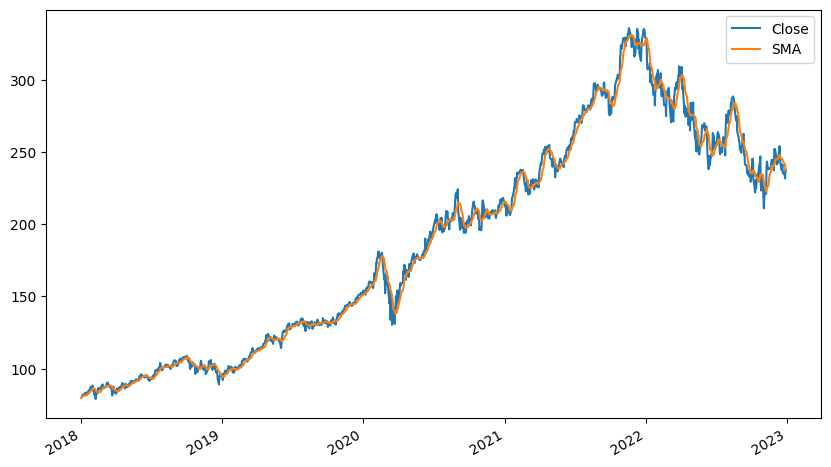

In [518]:
stockData['SMA']= stockData['Close'].rolling(window=10, min_periods=1).mean()
stockData[['Close', 'SMA']].plot(figsize=(10,6))

CUMULATIVE MOVING AVERAGE

<Axes: >

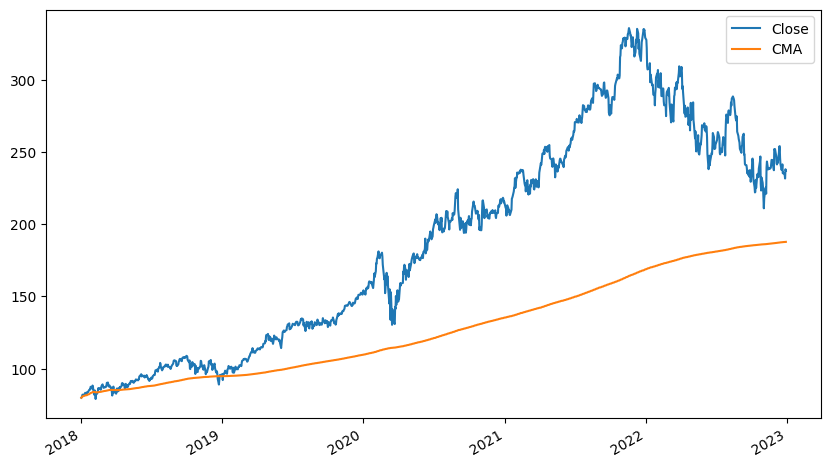

In [519]:
stockData['CMA']= stockData['Close'].expanding().mean()
stockData[['Close', 'CMA']].plot(figsize=(10,6))

EXPONENTIAL MOVING AVERAGE

<Axes: >

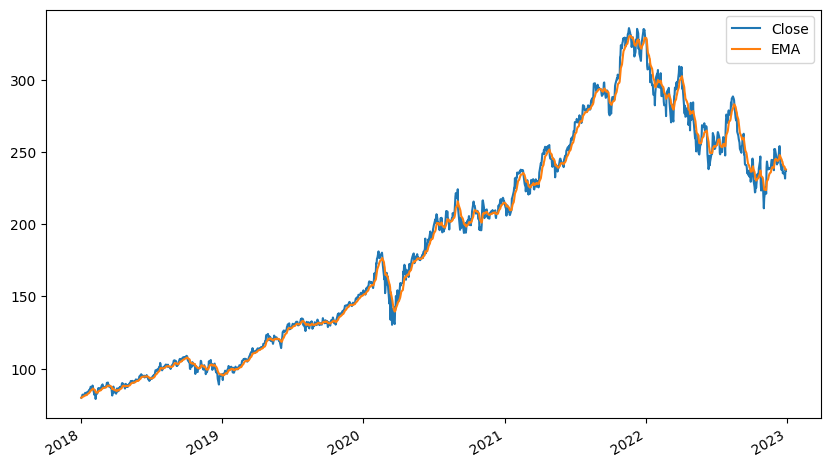

In [520]:
stockData['EMA']= stockData['Close'].ewm(span=10, adjust=False).mean()
stockData[['Close', 'EMA']].plot(figsize=(10,6))

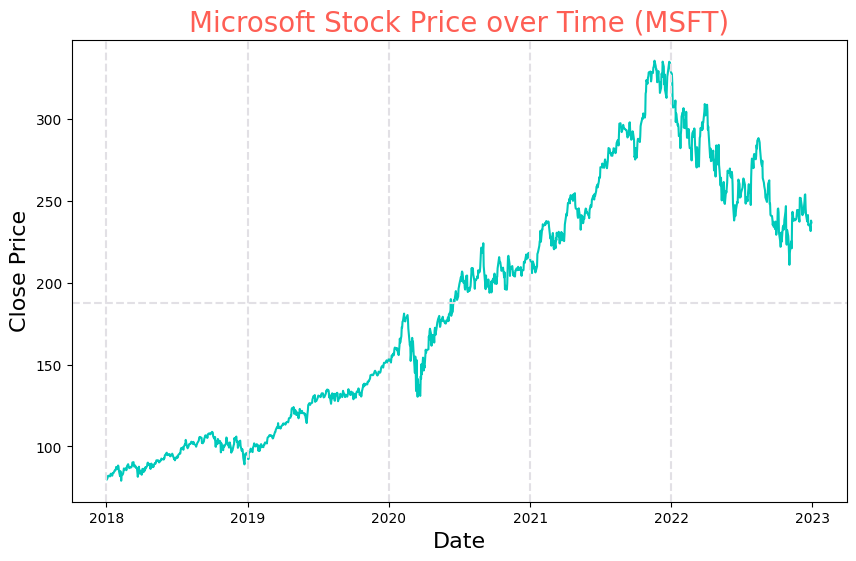

In [521]:
plt.figure(figsize=(10,6))
plt.plot(stockData.Close, color='#00C9BB')
plt.title('Microsoft Stock Price over Time (%s)'%tickerSymbol, fontsize=20, color='#FE5E54')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price', fontsize=16)
for year in range(2018,2023):
    plt.axvline(datetime(year,1,1), color='#E2E0E5', linestyle='--')
plt.axhline(stockData.Close.mean(), color='#E2E0E5', linestyle='--')

plt.show()

STATIONARITY

In [522]:
#Dickey-Fuller Test
def adf_test(series):
  result= adfuller(series)
  print('ADF Statistic: ', result[0])
  print('p-value: ', result[1])
  if result[1]<0.05:
      print('Series is Stationary')
  else:
      print('Series is Non-stationary')

In [523]:
adf_test(stockData.Close)

ADF Statistic:  -1.28747649915557
p-value:  0.6348821771061725
Series is Non-stationary


In [524]:
#Differencing to make data stationary
first_diffs= stockData.Close.values[1:] - stockData.Close.values[:-1]
first_diffs= np.concatenate((first_diffs, [0]))
stockData['FirstDifference']= first_diffs

In [525]:
#Check for stationarity again
adf_test(stockData.FirstDifference)

ADF Statistic:  -11.990086529081601
p-value:  3.537742501571597e-22
Series is Stationary


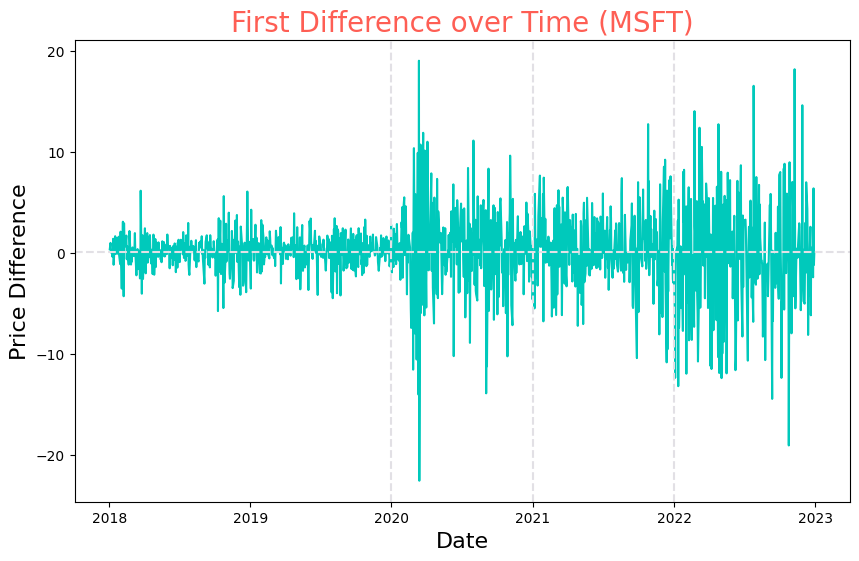

In [526]:
plt.figure(figsize=(10,6))
plt.plot(stockData.FirstDifference, color='#00C9BB')
plt.title('First Difference over Time (%s)'%tickerSymbol, fontsize=20, color='#FE5E54')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price Difference', fontsize=16)
for year in range(2020,2023):
    plt.axvline(datetime(year,1,1), color='#E2E0E5', linestyle='--')
plt.axhline(stockData.FirstDifference.mean(), color='#E2E0E5', linestyle='--')

plt.show()

SEASONALITY

In [527]:
twelth_difference= stockData['Close'] - stockData['Close'].shift(12)
stockData['TwelthDifference']= twelth_difference

In [528]:
#Check for Stationarity
adf_test(stockData.TwelthDifference.dropna())

ADF Statistic:  -8.15326824127385
p-value:  9.568734739819969e-13
Series is Stationary


ACF AND PACF

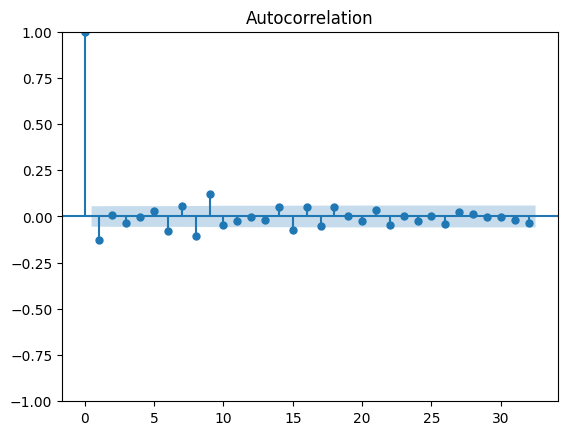

In [529]:
acf_plot= plot_acf(stockData.FirstDifference)

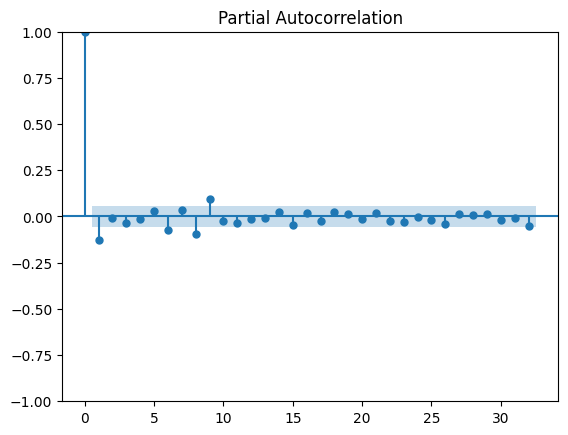

In [530]:
pacf_plot= plot_pacf(stockData.FirstDifference)

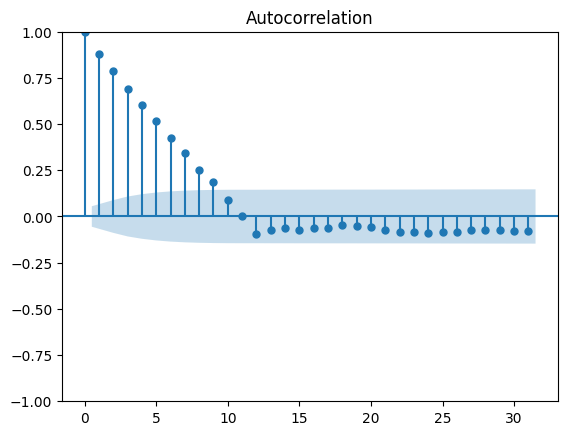

In [531]:
acf12_plot= plot_acf(stockData.TwelthDifference.dropna())

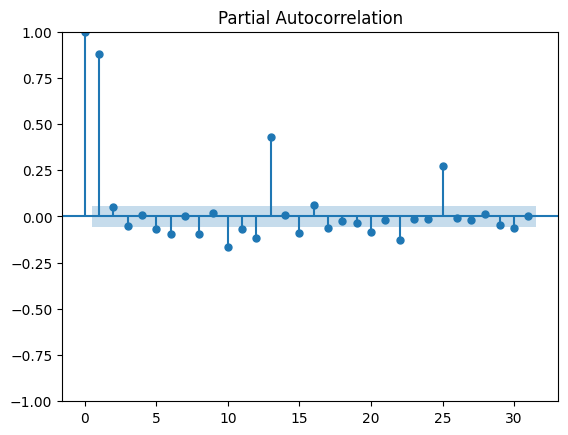

In [532]:
pacf12_plot= plot_pacf(stockData.TwelthDifference.dropna())

CREATING TRAIN AND TEST DATA

In [533]:
train_dataset_end= datetime(2022,6,30)
test_dataset_end= datetime(2022,12,30)

In [534]:
stockData['Date']= stockData.index
stockData.reset_index(drop=True, inplace=True)
stockData.head()

,Close,30 days Rolling,SMA,CMA,EMA,FirstDifference,TwelthDifference,Date
0,79.936737,NaN,79.936737,79.936737,79.936737,0.372002,NaN,2018-01-02
1,80.308739,NaN,80.122738,80.122738,80.004374,0.706848,NaN,2018-01-03
2,81.015587,NaN,80.420354,80.420354,80.188231,1.004433,NaN,2018-01-04
3,82.020020,NaN,80.820271,80.820271,80.521283,0.083710,NaN,2018-01-05
4,82.103729,NaN,81.076962,81.076962,80.809001,-0.055794,NaN,2018-01-08


In [535]:
train_data= stockData[stockData['Date']<=train_dataset_end]
test_data= stockData[stockData['Date']>train_dataset_end]

In [536]:
print(train_data)
print(test_data)

           Close  30 days Rolling         SMA         CMA         EMA  \
0      79.936737              NaN   79.936737   79.936737   79.936737   
1      80.308739              NaN   80.122738   80.122738   80.004374   
2      81.015587              NaN   80.420354   80.420354   80.188231   
3      82.020020              NaN   80.820271   80.820271   80.521283   
4      82.103729              NaN   81.076962   81.076962   80.809001   
...          ...              ...         ...         ...         ...   
1127  263.079163       255.740128  247.409378  180.722170  252.481678   
1128  260.317688       256.072077  248.578842  180.792671  253.906407   
1129  252.052826       255.939955  249.976295  180.855733  253.569393   
1130  255.767578       255.919239  251.526074  180.921968  253.969063   
1131  252.396774       255.612297  252.024324  180.985109  253.683192   

      FirstDifference  TwelthDifference       Date  
0            0.372002               NaN 2018-01-02  
1            0.70

ARIMA MODEL

In [537]:
model_ARIMA= ARIMA(train_data.Close, order=(6,1,1))

In [538]:
start= time()
model_ARIMA_fit= model_ARIMA.fit()
end= time()
print('Model Fitting Time', end-start)

Model Fitting Time 1.2564771175384521


In [539]:
print(model_ARIMA_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1132
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -3018.604
Date:                Mon, 24 Jun 2024   AIC                           6053.207
Time:                        08:25:58   BIC                           6093.454
Sample:                             0   HQIC                          6068.412
                               - 1132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8417      0.072    -11.685      0.000      -0.983      -0.700
ar.L2         -0.0938      0.030     -3.108      0.002      -0.153      -0.035
ar.L3          0.0184      0.027      0.672      0.5

In [540]:
pred_start = test_data.index[0]
pred_end = test_data.index[-1]

print(pred_start)
print(pred_end)

1132
1258


In [541]:
pred= model_ARIMA_fit.predict(start=pred_start, end=pred_end, typ='levels')
print(pred)

1132    252.162845
1133    251.690202
1134    252.416972
1135    252.701431
1136    251.981669
           ...    
1254    252.510530
1255    252.510530
1256    252.510530
1257    252.510530
1258    252.510530
Name: predicted_mean, Length: 127, dtype: float64


<Axes: ylabel='Density'>

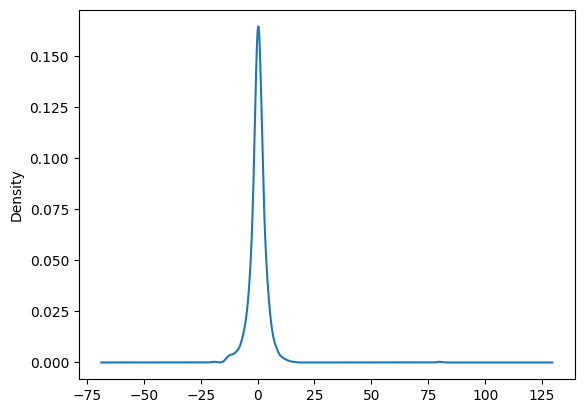

In [542]:
model_ARIMA_fit.resid.plot(kind='kde')

<Axes: >

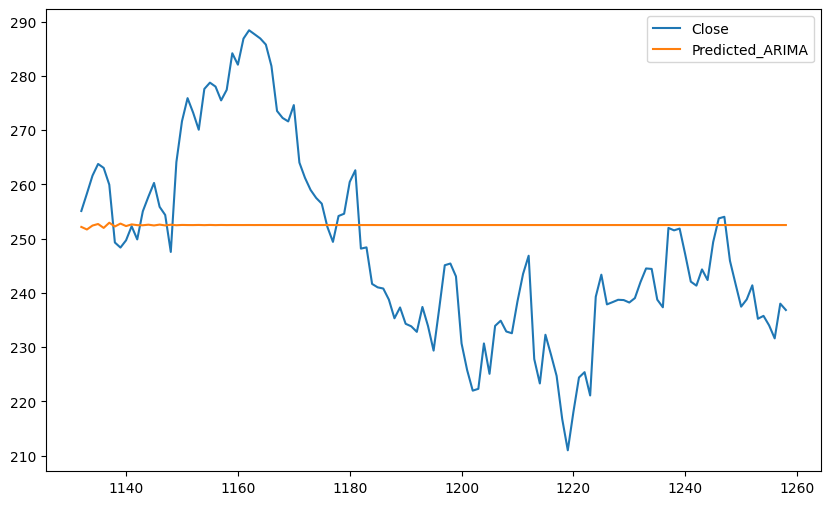

In [543]:
test_data['Predicted_ARIMA']= pred
test_data[['Close', 'Predicted_ARIMA']].plot(figsize=(10,6))

In [544]:
model_SARIMA= SARIMAX(train_data.Close, order=(2,0,9), seasonal_order=(0,1,0,12))
model_SARIMA_fit= model_SARIMA.fit()

In [545]:
print(model_SARIMA_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 1132
Model:             SARIMAX(2, 0, 9)x(0, 1, [], 12)   Log Likelihood               -3187.660
Date:                             Mon, 24 Jun 2024   AIC                           6399.319
Time:                                     08:26:27   BIC                           6459.572
Sample:                                          0   HQIC                          6422.093
                                            - 1132                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0336      0.025     41.620      0.000       0.985       1.082
ar.L2         -0.4507      

In [546]:
pred_SARIMA= model_SARIMA_fit.predict(start=pred_start, end=pred_end)
residuals= test_data['Close'] - pred_SARIMA
print(pred)

1132    252.162845
1133    251.690202
1134    252.416972
1135    252.701431
1136    251.981669
           ...    
1254    252.510530
1255    252.510530
1256    252.510530
1257    252.510530
1258    252.510530
Name: predicted_mean, Length: 127, dtype: float64


<Axes: ylabel='Density'>

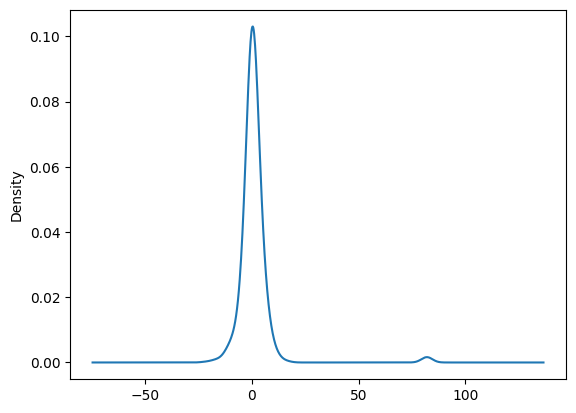

In [547]:
model_SARIMA_fit.resid.plot(kind='kde')

<Axes: >

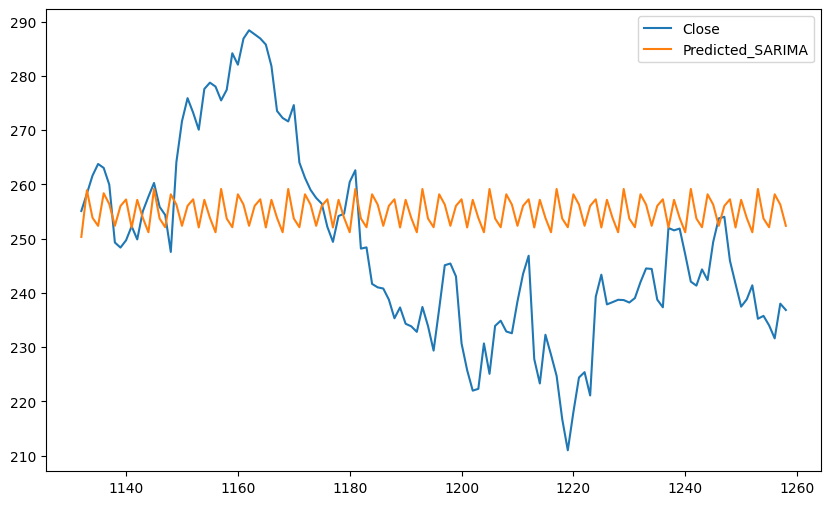

In [552]:
test_data['Predicted_SARIMA']= pred_SARIMA
test_data[['Close', 'Predicted_SARIMA']].plot(figsize=(10,6))

EXPONENTIAL SMOOTHING

In [549]:
model_EXP = SimpleExpSmoothing(train_data['Close']).fit(smoothing_level=0.2,optimized=False)

In [550]:
pred= model_EXP.forecast(len(test_data))
print(pred)

1132    253.734332
1133    253.734332
1134    253.734332
1135    253.734332
1136    253.734332
           ...    
1254    253.734332
1255    253.734332
1256    253.734332
1257    253.734332
1258    253.734332
Length: 127, dtype: float64


<Axes: >

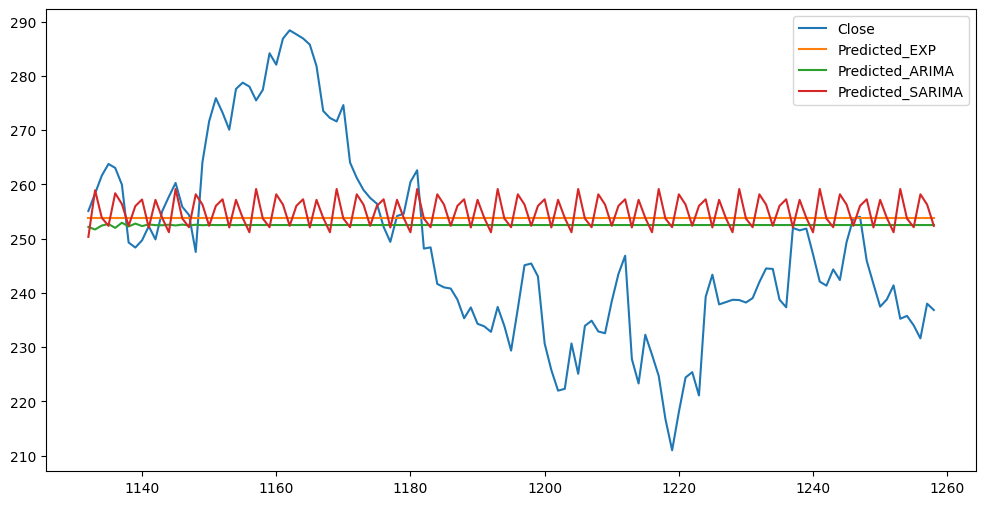

In [551]:
test_data['Predicted_EXP']= pred
test_data[['Close', 'Predicted_EXP', 'Predicted_ARIMA', 'Predicted_SARIMA']].plot(figsize=(12,6))